<a href="https://colab.research.google.com/github/Eldave93/mlp-handover/blob/main/workshops/week-06/6_Workshop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 06 - Non-Linear Regression
by Colin Rundel & David Elliott & Kit Searle

1. [Setup](#setup)

2. [Baseline model](#base)

3. [Polynomial regression](#poly)

4. [Regression trees](#RT)



---

# 1. Setup <a id='setup'></a>

## 1.1. Uploading your data to the colab
This notebook will be saved in your google drive in a folder "Colab Notebooks" by default, you should be fairly familiar with this by now.

When you run this cell you will need to give colab permission to access files in your drive.

In [1]:
import os
from google.colab import drive

drive.mount('/content/drive')
os.chdir('drive/My Drive/Colab Notebooks/mlp/week-6')
!ls

Mounted at /content/drive
6_Kit_Updates.ipynb  week06.ipynb  week-06.zip	ws-material


We will now unzip the workshop materials and place them in a subdirectory "ws-material/"

In [2]:
if not os.path.exists('ws-material'):
  print('Unzipping materials...')
  !unzip week-06.zip -d ws-material
else:
  print("Directory already exists!")

os.chdir('ws-material')
!ls

Directory already exists!
Data  Images  scripts


## 1.2. Packages

Now lets load in the packages you wil need for this workshop.

In [3]:
# Display plots inline
%matplotlib inline

# Data libraries
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80

# sklearn modules
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

## 1.3 Data

The data set we will be using today is synthetic data that was generated via a random draw from a Gaussian Process model. The resulting data represent an unknown smooth function $y = f(x) + \epsilon$. We will be implementing a variety of approaches for deriving a parameterized model of this function using least squares regression.

We can read the data in from `gp.csv` and generate a scatter plot to get a sense of the shape of the function.

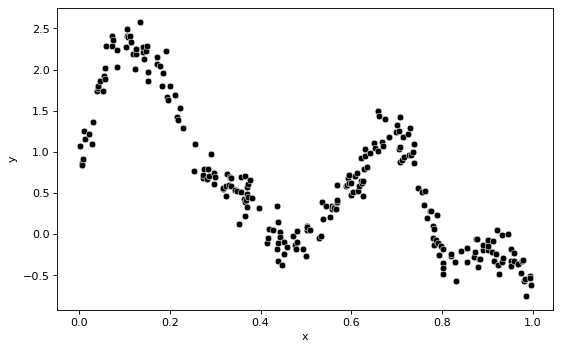

In [4]:
d = pd.read_csv("./Data/gp.csv")
n = d.shape[0] # number of rows

sns.scatterplot(x='x', y='y', data=d, color="black")

---

#2. Baseline model <a id='base'></a>

Lets start by making a baseline model to compare to.

---

### 🚩 Exercise 1

Fit a linear regression model to the training data, and create a plot of the regression line overlayed on the original data.


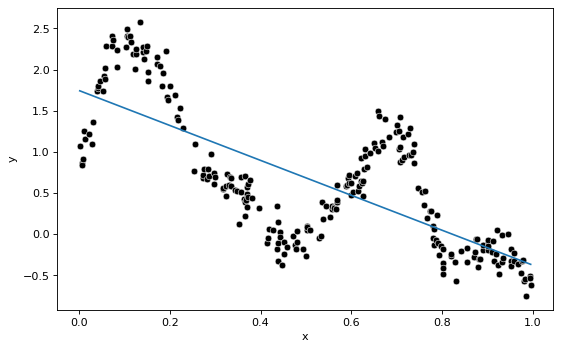

In [5]:
X = np.c_[np.ones(n), d.x]
d["pred_lm"] = LinearRegression(fit_intercept = False).fit(X, d.y).predict(X)

sns.scatterplot(x='x', y='y', data=d, color="black")
sns.lineplot(x='x', y='pred_lm', data=d)

---

### 🚩 Exercise 2

Calculate the mean squared error of your linear model's predictions. The function `mean_squared_error` from `sklearn.metrics` will be useful for this. See the functions documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html).

In [6]:
from sklearn.metrics import mean_squared_error

mean_squared_error(d.y, d.pred_lm)

0.30684493321337125

---

# 3. Polynomial regression <a id='poly'></a>

Polynomial regression is a straight forward approach to capturing simple non-linear relationships between a feature and our response variable. At its core, polynomial regression amounts to the inclusion of additional columns in the model matrix that are powers of the feature of interest.

## 3.1 By hand

For a single feature and low order polynomials this is can be done by hand. For example, if we want to fit a quadratic model to these data we can do the following,

In [7]:
y = d.y
X = np.c_[
    np.ones(n),
    d.x,
    d.x**2
]

l = LinearRegression(fit_intercept = False).fit(X,y)

print(l.coef_)

[ 1.96397561 -3.42899677  1.30199921]


Which gives us the following model for the data,

$$ \hat{y} = 1.96 - 3.43 x + 1.30 x^2 $$

The predictons of this model are then,

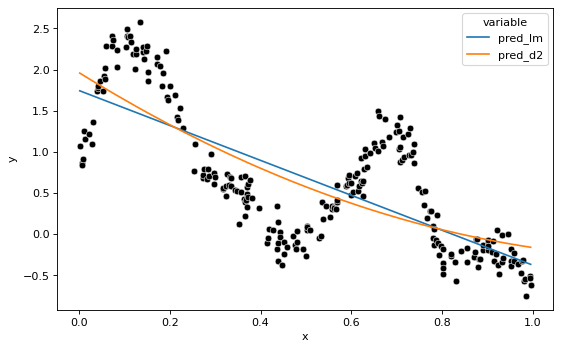

In [8]:
d["pred_d2"] = l.predict(X)

sns.scatterplot(x='x', y='y', data=d, color="black")
sns.lineplot(x='x', y='value', hue="variable", data=pd.melt(d,id_vars=["x","y"]))

Note that the predicted values from this model form a curve rather than a straight line - specifically we have found the quadratic curve that best fits our data. We have used the pandas function melt to restructure our data frame, this is not strictly needed here but will be necessary for later examples. See the pandas documentation on melt for futher details.

---

### 🚩 Exercise 3

Calculate the mean square error of this quadratic polynomial model. How does it compare to the linear model we previously fit?

In [9]:
mean_squared_error(d.y, d.pred_d2)

0.2969616424742076

This MSE is slightly better than the MSE for the linear model.

---

A cubic model can be similarly fit by adding a column containing $x^3$ to the previous model matrix (`X`). Note that by convention when fitting a polynomial model of degree $n$ we include all powers from $0$ to $n$, so for a cubic model our model matrix should include $x^0$, $x^1$, $x^2$, and $x^3$. 

In [10]:
X = np.c_[X, d.x**3]
l = LinearRegression(fit_intercept = False).fit(X,y)

print(l.coef_)

[ 2.36985684 -8.49429068 13.95066369 -8.39215284]


This gives us a cubic model with the form,

$$
\hat{y} = 2.37 - 8.49 x + 13.9 x^2 - 8.39 x^3
$$

and predictons of this model are then,

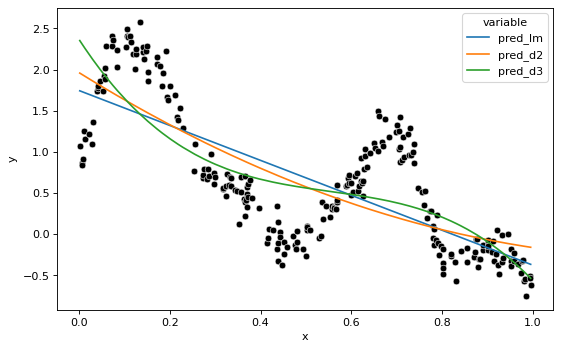

In [11]:
d["pred_d3"] = l.predict(X)

sns.scatterplot(x='x', y='y', data=d, color="black")
sns.lineplot(x='x', y='value', hue="variable", data=pd.melt(d,id_vars=["x","y"]))

---

### 🚩 Exercise 4

Calculate the mean square error of the cubic polynomial model. How does this model compare to your previous models?

In [12]:
mean_squared_error(d.y, d.pred_d3)

0.27124908717801827

This is better still than the previous two MSEs.

---

## 3.2 sklearn and polynomial features

sklearn has a built in function called `PolynomialFeatures` which can be used to simplify the process of including polynomial features in a model. This function is included in the *preprocessing* module of sklearn, as with other python functions we can import it as follows.

In [13]:
from sklearn.preprocessing import PolynomialFeatures

Construction and use of this and other transformers is similar to what we have already seen with LinearRegression, we construct a PolynomialFeatures object in which we set basic options (e.g. the degree of the polynomial) and then apply the transformation to our data via fit_transform method. This will generate a new model matrix which includes the polynomial features up to the degree we have specified.

To demonstrate the core features we will start with a toy example and then replicate the models we constructed in Section 3.1. Below we construct our sample data vector and then pass it into the transformer,

In [14]:
x = np.array([1,2,3,4]) # Initial data

In [15]:
PolynomialFeatures(degree = 2).fit_transform(x)

ValueError: ignored

When we run the above code we get an error because currently x is a 1D vector when the fit_transform function is expected a 2D array (the same will also happen with LinearRegression's fit method). To solve this we need to make sure that the value we pass has the correct dimensions, x.reshape(-1, 1) is suggested by the error and corrects the issue.

In [16]:
PolynomialFeatures(degree = 2).fit_transform(x.reshape(-1,1))

array([[ 1.,  1.,  1.],
       [ 1.,  2.,  4.],
       [ 1.,  3.,  9.],
       [ 1.,  4., 16.]])

Alternatively, we can alsu use the np.c_ function to construct the matrix.

In [17]:
PolynomialFeatures(degree = 2).fit_transform(np.c_[x]) # Order 2 polynomial model matrix for x

array([[ 1.,  1.,  1.],
       [ 1.,  2.,  4.],
       [ 1.,  3.,  9.],
       [ 1.,  4., 16.]])

In [18]:
PolynomialFeatures(degree = 3).fit_transform(np.c_[x]) # Order 3 polynomial model matrix for x

array([[ 1.,  1.,  1.,  1.],
       [ 1.,  2.,  4.,  8.],
       [ 1.,  3.,  9., 27.],
       [ 1.,  4., 16., 64.]])

Note that when we use this transform we get all of the polynomial transformations of x from 0 to degree. In this case, the 0 degree column is equivalent to the intercept column. If for some reason we did not want to include this we can construct PolynomialFeatures with include_bias=False.

In [19]:
PolynomialFeatures(degree = 3, include_bias=False).fit_transform(np.c_[x])

array([[ 1.,  1.,  1.],
       [ 2.,  4.,  8.],
       [ 3.,  9., 27.],
       [ 4., 16., 64.]])

We can now apply this to our original data by storing the result as X then passing this new model matrix to the linear regression fit method.

In [20]:
X = PolynomialFeatures(degree = 3).fit_transform(np.c_[d.x])

l = LinearRegression(fit_intercept = False).fit(X,d.y)
print(l.coef_)

[ 2.36985684 -8.49429068 13.95066369 -8.39215284]


These values match those we obtained from the earlier cubic model, and we can also see this when plotting the model predictons.

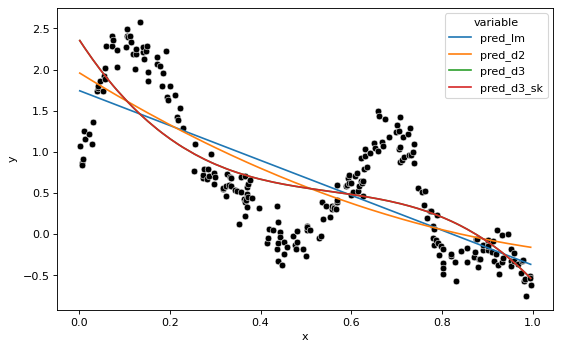

In [21]:
d["pred_d3_sk"] = l.predict(X)

sns.scatterplot(x='x', y='y', data=d, color="black")
sns.lineplot(x='x', y='value', hue="variable", data=pd.melt(d,id_vars=["x","y"]))

We can not even see the pred_d3 line as it is being overplotted by the pred_d3_sk line.

## 3.3 Pipelines

You may have noticed that `PolynomialFeatures` takes a model matrix as input and returns a new model matrix as output which is then used as the input for `LinearRegression`. This is not an accident, and by structuring the library in this way sklearn is designed to enable the connection of these steps together, into what sklearn calls a *pipeline*.

We can modularize and simply our code somewhat by creating a pipeline that takes our original data, performs a polynomial feature transform and then feeds the results into a linear regression. We can accomplish this via the `make_pipeline` function from the `pipeline` module.

In [22]:
from sklearn.pipeline import make_pipeline

poly_model = make_pipeline(
    PolynomialFeatures(degree=4),
    LinearRegression()
)

print(poly_model)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=4)),
                ('linearregression', LinearRegression())])


The resulting object represents a new "model" which can then be fit to data.

In [23]:
p = poly_model.fit(np.c_[d.x], d.y)
print(p)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=4)),
                ('linearregression', LinearRegression())])


and used to create predictions just like our previous `LinearRegression` model.

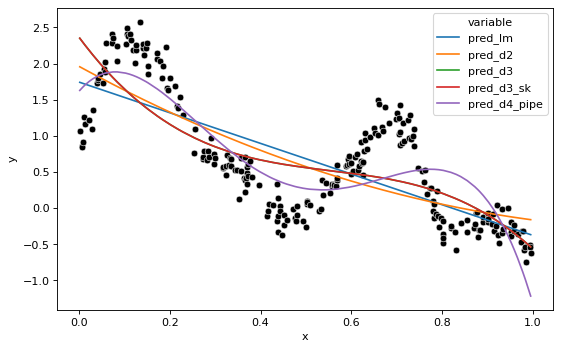

In [24]:
d['pred_d4_pipe'] = p.predict(np.c_[d.x])

sns.scatterplot(x='x', y='y', data=d, color="black")
sns.lineplot(x='x', y='value', hue="variable", data=pd.melt(d,id_vars=["x","y"]))

The returned object is a `Pipeline` object so it will not provide direct access to step properties, such as the coefficients for the regression model.

In [25]:
print(p.coef_)

AttributeError: ignored

If we want access to the attributes or methods of a particular step we need to first access that step using either its name or position.

In [26]:
print(p.named_steps['linearregression'].coef_)

[  0.           7.39051417 -57.67175293 102.72227443 -55.38181361]


In [27]:
print(p.steps[1][1].intercept_) # second subset is necessary here because 
                                # each step is a tuple of a name and the 
                                # model / transform object 

1.6136636604768249


Also note that both the `'linearregression'` and `'polynomialfeatures'` step introduce a column of ones into the model matrix. This potentially introduces a rank deficiency in our model matrix, however sklearn handles this by fixing the coefficient of the duplicate intercept column to 0. The result however is that the intercept is now stored in `intercept_` and not `coef_`. If we wished to avoid this we would need to construct our pipeline using `LinearRegression(fit_intercept=False)`.

In [28]:
p = make_pipeline(
    PolynomialFeatures(degree=4),
    LinearRegression(fit_intercept = False)
).fit(
    np.c_[d.x],
    d.y
)

print(p.named_steps['linearregression'].coef_)
print(p.named_steps['linearregression'].intercept_)

[  1.61366366   7.39051417 -57.67175293 102.72227443 -55.38181361]
0.0


## 3.4 Putting it all together

So far each time we've wanted to fit a polynomial regression model we've had to set up the various data objects and then create the sklearn model and transformation objects and then get a final result of the coefficients or a plot - because of this the preceeding cells contain a lot of duplicated code which is something we should be trying to avoid. 

Our modeling task here is like many other programming tasks, when we find ourselves reusing the same code over and over it is time to consider writing a function. Below I have implemented a function called `poly_reg` that allows the user to provide a data frame and specific the names of the `x` column an d `y` column as well as the degree of the polynomial we would like to fit. The function returns the original data frame with the model predictions added as well as the model coefficients in a tuple.

In [29]:
def poly_reg(data, x = 'x', y = 'y', degree=1, plot_data = True, plot_fit = True):
    X = np.c_[data[x]]
    Y = data[y]
    
    p = make_pipeline(
        PolynomialFeatures(degree=degree),
        LinearRegression(fit_intercept=False)
    )
    
    m = p.fit(X,Y)
    
    pred_col = 'pred_d'+str(degree)
    data[pred_col] = m.predict(X)

    if plot_data:
        sns.scatterplot(x=data[x], y=data[y], color="black")

    if plot_fit:
        sns.lineplot(x=data[x], y=data[pred_col])
    
    return (data, m.steps[1][1])

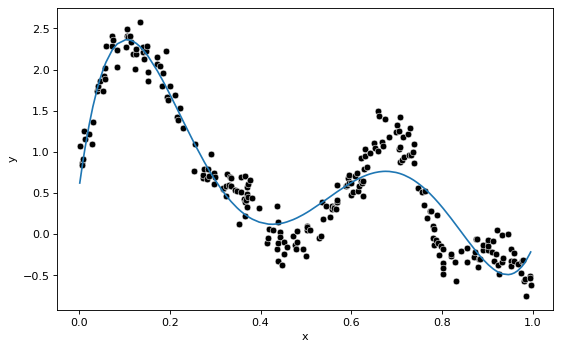

In [30]:
_, _ = poly_reg(d, degree=5)

Since we are not using either the data frame or model coefficients we unpack them into `_`.

---

### 🚩 Exercise 5

Use the `poly_reg` function to fit a variety of different polynomial models to the data. What values of `degree` provides the best fit (judged qualitatively not quantitatively).

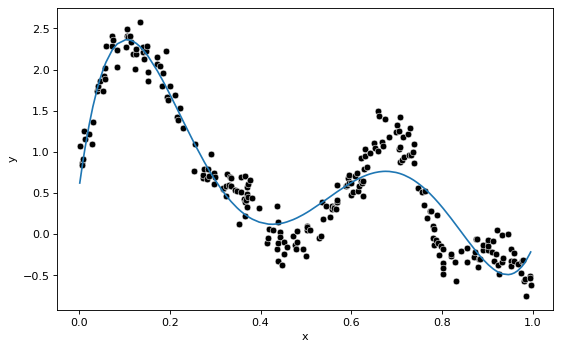

In [31]:
_, _ = poly_reg(d, degree=5)

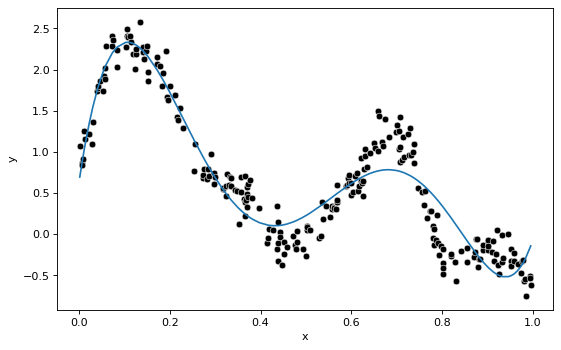

In [32]:
_, _ = poly_reg(d, degree=6)

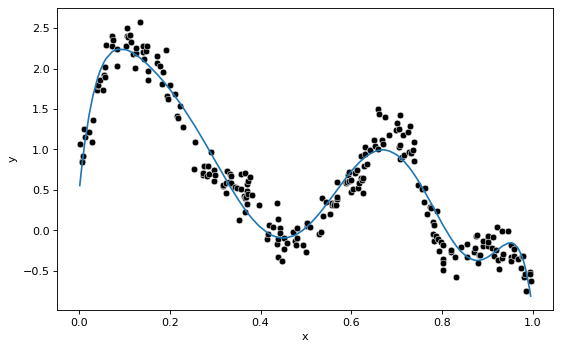

In [33]:
_, _ = poly_reg(d, degree=8)

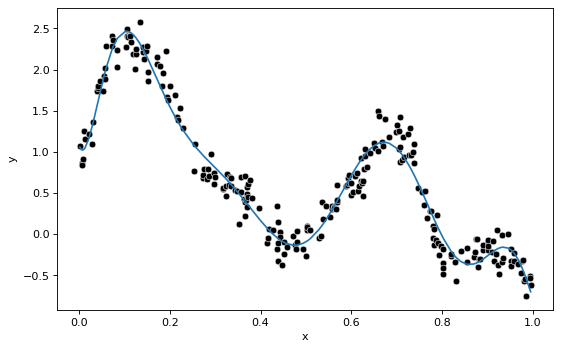

In [34]:
_, _ = poly_reg(d, degree=10)

As we increase the degrees of the polynomial the model appears to fit the data better, there also appears to be some diminishing returns as the degree gets larger.

---

### 🚩 Exercise 6


In the cell below we have provided a copy of the `poly_reg` function, modify this function such that it returns a 3rd value that is the mean square error of the predictions for the model. Check that the value returned by the function matches the MSE you calculated in **Exercises 2-4**.

In [35]:
def poly_reg_mse(data, x = 'x', y = 'y', degree=1, plot_data = True, plot_fit = True):
    X = np.c_[data[x]]
    Y = data[y]
    
    p = make_pipeline(
        PolynomialFeatures(degree=degree),
        LinearRegression(fit_intercept=False)
    )
    
    m = p.fit(X,Y)
    
    pred_col = 'pred_d'+str(degree)
    data[pred_col] = m.predict(X)

    if plot_data:
        sns.scatterplot(data[x],data[y], color="black")

    if plot_fit:
        sns.lineplot(data[x],data[pred_col])
    
    # Only the line below needs to change
    return (data, m.steps[1][1], mean_squared_error(data[y], data[pred_col]))

Below are three calls to this function which report these MSE values.

In [36]:
_, _, mse_d1 = poly_reg_mse(d, degree=1, plot_data=False, plot_fit=False)
_, _, mse_d2 = poly_reg_mse(d, degree=2, plot_data=False, plot_fit=False)
_, _, mse_d3 = poly_reg_mse(d, degree=3, plot_data=False, plot_fit=False)


print("deg=1:", mse_d1)
print("deg=2:", mse_d2)
print("deg=3:", mse_d3)

deg=1: 0.30684493321337125
deg=2: 0.2969616424742076
deg=3: 0.27124908717801827


---

### 🚩 Exercise 7


Construct a data frame called `poly_res` with the columns `degree` and `mse`. `degree` should contain the integer values 1 to 20 and `mse` should contain the mean squared errors, calculated using the function `poly_reg_mse`, for each of the different `degree` values.

In [37]:
poly_res = pd.DataFrame(
    {'degree': range(1,21)}
).assign(
    mse = lambda x: [ poly_reg_mse(d, degree=i, plot_data=False, plot_fit=False)[2] for i in x.degree]
)

poly_res

,degree,mse
0,1,0.306845
1,2,0.296962
2,3,0.271249
3,4,0.203277
4,5,0.077071
5,6,0.076422
6,7,0.067818
7,8,0.047326
8,9,0.043203
9,10,0.031921


---

### 🚩 Exercise 8

Create a plot of `degree` vs. `mse` using the `poly_res` data frame you created above. Based on this comment on what model appears to best fit the data. 

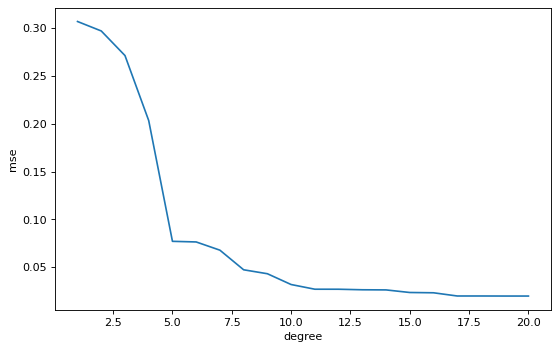

In [38]:
sns.lineplot(x="degree", y="mse", data=poly_res)

Based on this plot it seems that the MSE gets smaller as the degree increases, however after around a degree of 10 the improvements are quite small.

---

### 🚩 Exercise 9

Based on your findings in the preceding exercises, can we find the "optimal model" using this kind of approach? Explain why or why not.

The optimal model would appear to be a model with the largest possible degree, but this risks issues of overfitting.

## 3.5 Chosing the order of the polynomial

We saw above that increasing the order of the polynomial apears to provide a better fit to the data. In the lecture we discussed how chosing $M$ to be too large can cause over fittting. When we over fit a polynomial regression model, the MSE for the training data will apear to be low which might indicate that the model is a good fit. As a result of over fitting, the MSE for the predictions of the unseen test data may begin to decrease. We will illustrate this next.

First, we will read in clean data and create our training and testing subsets.



In [39]:
d = pd.read_csv("./Data/gp.csv")

from sklearn.model_selection import train_test_split

X = d.drop('y',axis=1) # Independet variable
y = d['y'] # dependent variable
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3,random_state=23)

#full datasets for plotting purposes
train_full = X_train.join(y_train)
test_full = X_test.join(y_test)

Next, we will update our `poly_reg_mse` function so that it can take as input a training dataset and a testing data set. The new function will return the mse for both the train and test dataset (as well as a plot with black representing the training points and red representing the testing points. 

In [40]:
def poly_reg_mse_2(train_data,test_data, x = 'x', y = 'y', degree=1, plot_data = True, plot_fit = True):
    X = np.c_[train_data[x]]
    Y = train_data[y]
    
    p = make_pipeline(
        PolynomialFeatures(degree=degree),
        LinearRegression(fit_intercept=False)
    )
    
    m = p.fit(X,Y)
    
    pred_col = 'pred_d'+str(degree)
    train_data[pred_col] = m.predict(X)
    test_data[pred_col] = m.predict(np.c_[test_data[x]])
    if plot_data:
        sns.scatterplot(train_data[x],train_data[y], color="black")
        sns.scatterplot(test_data[x],test_data[y], color="red")

    if plot_fit:
        sns.lineplot(train_data[x],train_data[pred_col])

    test_mse = mean_squared_error(test_data[y], test_data[pred_col])
    train_mse = mean_squared_error(train_data[y], train_data[pred_col])
  
    return (test_data, m.steps[1][1], train_mse, test_mse)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


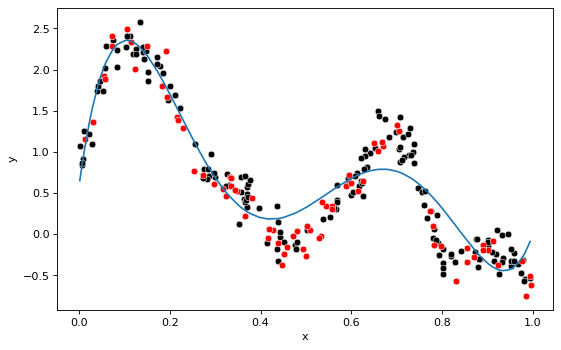

In [41]:
_, _, mse_test, mse_train = poly_reg_mse_2(train_full,test_full, degree=5)

---

### 🚩 Exercise 10

Change the values for degree. What do you notice about the fit as we increase the polynomial degree?

As we increase $M$ the regression function better fits the training data but becomes worse at predicting the unseen test data.

---

### 🚩 Exercise 11


Construct a data frame called `poly_res_2` with the columns `degree`, `mse_train` and `mse_test`. `degree` should contain the integer values 1 to 80 and `mse_train` and `mse_test` should contain the mean squared errors computed using the training data and testing data, respectively, calculated using the function `poly_reg_mse_2`, for each of the different `degree` values.

In [43]:
poly_res_2 = pd.DataFrame(
    {'degree': range(1,80)}
).assign(
    mse_train = lambda x: [ poly_reg_mse_2(train_full,test_full, degree=i, plot_data=False, plot_fit=False)[2] for i in x.degree],
    mse_test = lambda x: [ poly_reg_mse_2(train_full,test_full, degree=i, plot_data=False, plot_fit=False)[3] for i in x.degree]
)

poly_res_2

,degree,mse_train,mse_test
0,1,0.295354,0.343235
1,2,0.292836,0.323342
2,3,0.273160,0.282803
3,4,0.203195,0.210916
4,5,0.077044,0.083487
...,...,...,...
74,75,0.021536,0.023854
75,76,0.020065,0.031349
76,77,0.020216,0.032213
77,78,0.020364,0.036121


---

### 🚩 Exercise 12

Create a plot of `degree` vs. `mse_train` and `mse_test` using the `poly_res` data frame you created above. Based on this comment on what model appears to best fit the data.

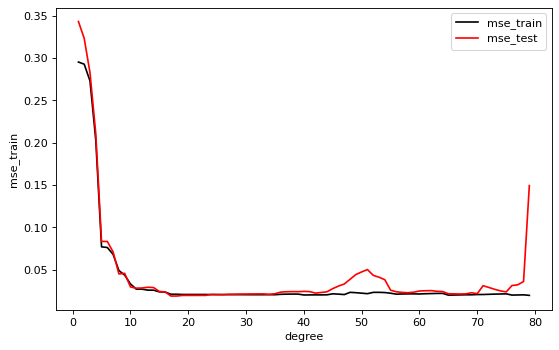

In [44]:
f, ax = plt.subplots(1, 1)
sns.lineplot(ax=ax, x="degree", y="mse_train", data=poly_res_2,color="black")
sns.lineplot(ax=ax, x="degree", y="mse_test", data=poly_res_2,color="red")
ax.legend(labels=["mse_train","mse_test"])

At first, as the degree of the polynomial increases, the mse for both the test and train dataset improve. As the degree becomes too large, the mse for the test set begins to deteriorate because of overfitting.

If we wish to test over a specific set of parameter values using cross validation we can use the `GridSearchCV` function from the `model_selection` submodule.

This argument is a dictionary containing parameters names as keys and lists of parameter settings to try as values. Since we are using a pipeline, out parameter name will be the name of the pipeline step, `polynomialfeatures`, followed by `__`, and then the parameter name, `degree`. So for our pipeline the parameter is named `polynomialfeatures__degree`. If you want to list any models available parameters you can call the `get_params()` method on the model object, e.g. `m.get_params()` here.

In [45]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

m = make_pipeline(
        PolynomialFeatures(),
        LinearRegression(fit_intercept=False)
    )

parameters = {
    'polynomialfeatures__degree': np.arange(1,31,1)
}

kf = KFold(n_splits=5, shuffle=True, random_state=0)

grid_search = GridSearchCV(m, parameters, cv=kf, scoring="neg_mean_squared_error").fit(X, y)

The above code goes through the process of fitting all $5 \times 30$ models as well as storing and ranking the results for the requested scoring metric(s). Note that here we have used "neg_mean_squared_error" as our scoring metric which returns the negative of the root mean squared error. As the name implies this returns the negative of the usual fit metric, this is because sklearn expects to always optimize for the maximum of a score and the model with the largest negative MSE will therefore be the "best". 

In this workshop we have used MSE as a metric for testing our models. This metric is entirely equivalent to the root mean squared error for purposes of ranking / ordering models (as the square root is a monotonic transformation). Sometimes the rmse is prefered as it is more interpretable, because it has the same units as $y$.

Once all of the submodels are fit, we can determine the optimal hyperparameter value by accessing the object's `best_*` attributes,

In [46]:
print("best index: ", grid_search.best_index_)
print("best param: ", grid_search.best_params_)
print("best score: ", grid_search.best_score_)

best index:  16
best param:  {'polynomialfeatures__degree': 17}
best score:  -0.02297684413925504


# 4. Regression trees (via feature engineering) <a id='RT'></a>


Reacll that regression trees assume the basis function of the form,

$$
f_j(x; a_j,b_j) = \begin{cases}
1 & \text{if $a_j \leq x < b_j$} \\
0 & \text{otherwise}
\end{cases}
$$

This reflects one possible basis function that we might choose to better fit our data. In order to use these functions to transform our data, we will need to choose the values of $a$ and $b$ as well as the number of basis functions to use $M$. Given those choices our goal is to then to fit the model,

$$
y_i = \beta_1 f(x_i; a_1,b_1) + \beta_2 f(x_i; a_2,b_2) + \ldots +  \beta_M f(x_i; a_M,b_M) 
$$

---

### 🚩 Exercise 13

Explain why we are not able to directly use the least squares approach to find optimal values of $a$, $b$, and $M$ to fit our data.

Using least squares we are only able to solve for parameters that are a linear function of our features. For this model this is only true of the $\beta$s but not $a$, $b$, and $M$ - we can try fitting different models with different values of these, but the naive parameter space is too large to be practically searched.



---

## 4.1 With pandas

For our example today, we will keep things simple and divide our `x` values up into 11 equal sized pieces: $[0,0.1)$, $[0.1,0.2)$, $\ldots$, $[0.9,1)$. This can be achieved using pandas' `cut` function as follows, 

In [47]:
d = pd.read_csv("./Data/gp.csv") # Get a clean copy of the data

d["x_bin"] = pd.cut(d.x, np.linspace(0,1,11))
print(d)

            x         y       x_bin
0    0.002189  1.070772  (0.0, 0.1]
1    0.006209  0.863336  (0.0, 0.1]
2    0.006764  0.846165  (0.0, 0.1]
3    0.009349  0.916748  (0.0, 0.1]
4    0.012407  1.258828  (0.0, 0.1]
..        ...       ...         ...
245  0.982005 -0.540678  (0.9, 1.0]
246  0.983324 -0.751002  (0.9, 1.0]
247  0.992081 -0.510908  (0.9, 1.0]
248  0.993567 -0.537508  (0.9, 1.0]
249  0.994654 -0.621642  (0.9, 1.0]

[250 rows x 3 columns]


`np.linspace` is used here to specify the cut points and returns the array `[0,0.1,...,0.9,1]`. The results new column `x_bin` now contains a categorical variable for the interval containing the `x` value for that row. 

We can then use pandas' `get_dummies` to transform this categorical variable using one hot encoding. After brief examination you should be able to see that this is equivalent applying the 11 basis functions (columns) to each of the `x` values (rows) using the ranges we've described.

In [48]:
pd.get_dummies(d.x_bin)

,"(0.0, 0.1]","(0.1, 0.2]","(0.2, 0.3]","(0.3, 0.4]","(0.4, 0.5]","(0.5, 0.6]","(0.6, 0.7]","(0.7, 0.8]","(0.8, 0.9]","(0.9, 1.0]"
0,1,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
245,0,0,0,0,0,0,0,0,0,1
246,0,0,0,0,0,0,0,0,0,1
247,0,0,0,0,0,0,0,0,0,1
248,0,0,0,0,0,0,0,0,0,1


We can then fit a linear regression model using only these dummy variable and obtain the following model fit,

In [49]:
X = pd.get_dummies(d.x_bin)
y = d.y
l = LinearRegression(fit_intercept=False).fit(X.values,y)
d["pred_M11"] = l.predict(X.values)

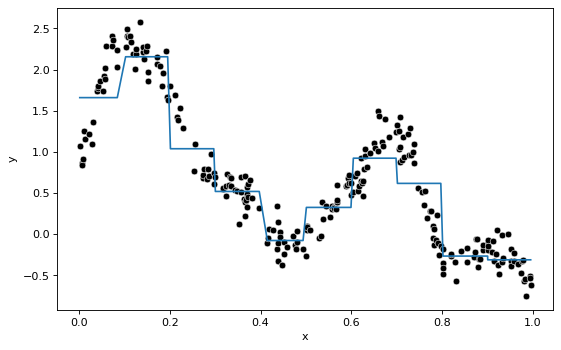

In [50]:
sns.scatterplot(x='x', y='y', data=d, color="black")
sns.lineplot(x='x', y='pred_M11', data=d)

In [51]:
l.coef_

array([ 1.65848553,  2.15479111,  1.03790691,  0.51923971, -0.07654133,
        0.32542526,  0.92304333,  0.61710898, -0.26557377, -0.31101199])

---

### 🚩 Exercise 14

Calculate the mean squared error of this model. How does it compare to the polynomial models we fit previously?

In [52]:
mean_squared_error(d.y, d.pred_M11)

0.0985882258438611

This model performs reasonably well, it is competative with polynomial models with degree <5.

---

### 🚩 Exercise 15

Repeat this fitting procedure, but vary the number of bins being used (by changing the 3rd parameter in `np.linspace`). How does the MSE compare to the previous models?

0.03245514022311238

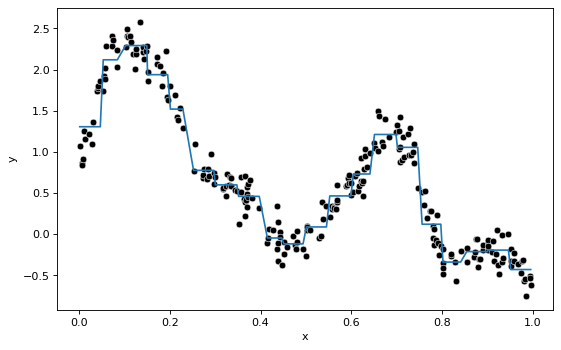

In [53]:
X = pd.get_dummies(pd.cut(d.x, np.linspace(0,1,21)))
d["pred_M21"] = LinearRegression(fit_intercept=False).fit(X.values,d.y).predict(X.values)

sns.scatterplot(x='x', y='y', data=d, color="black")
sns.lineplot(x='x', y='pred_M21', data=d)

mean_squared_error(d.y, d.pred_M21)

Increasing the number of bins improves the model fit.

---

## 4.2 With sklearn

A similar process can be achieved with sklearn's `KBinsDiscretizer` from the *preprocessing* submodule. 

In [54]:
from sklearn.preprocessing import KBinsDiscretizer

The key arguments for this transformer are `n_bins` which determines the number of bins, `encode` which determines how the transformed values are encoded, and `strategy` which is used to determine bin widths. To (almost) replicate our results from pandas we will use `strategy="uniform"` and `encode="onehot-dense"`.

In [55]:
kb_disc = KBinsDiscretizer(n_bins=10, strategy="uniform", encode="onehot-dense")
kb_disc

KBinsDiscretizer(encode='onehot-dense', n_bins=10, strategy='uniform')

We can examine where the transformer has selected the bin edges to be located by calling the fit method on our features and then printing the `bin_edges_` attribute.

In [56]:
X = np.c_[d.x]
kb_disc.fit(X).bin_edges_

array([array([0.00218943, 0.10143587, 0.20068231, 0.29992875, 0.39917519,
       0.49842163, 0.59766807, 0.69691451, 0.79616095, 0.89540739,
       0.99465383])], dtype=object)

These cut points differ slightly from those we obtained from pandas, this is happening because we are using the data to derive the cut points and since the x values are randomly generated the data does not begin exactly at 0 and end at 1.

If we want to match pandas exactly, we can provide new data which is used to fit the transformer and then apply that to our data using the transform later.

In [57]:
x_range = np.array([0,1])
kb_disc.fit(x_range.reshape(-1,1)).bin_edges_

array([array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])],
      dtype=object)

To obtain the transformed feature, we need to call transform with the feature to transform.

In [58]:
kb_disc.fit(x_range.reshape(-1,1)).transform(X)

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

If instead we used fit_transform we will get the bin edges from the first example above, this will be the default behavior of the transformer if we use it in a pipeline.

In [59]:
kb_disc.fit_transform(X)

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

The two data frames above look similar, but are very slightly different due to the different bin edges used.

Just like our polynomial regression model, we can combine this transformed with the model using a pipeline. This combined with some plotting and diagnostic code is below.

In [60]:
def reg_tree(data, x = 'x', y = 'y', 
             n_bins=10, strategy = "uniform",
             x_range = np.array([0,1]),
             plot_data = True, plot_fit = True):
    
    X = np.c_[data[x]]
    Y = data[y]
    
    p = make_pipeline(
        KBinsDiscretizer(n_bins=n_bins, strategy=strategy, encode="onehot-dense"),
        LinearRegression(fit_intercept=False) # Since we are using onehot above we 
    )                                         # need to remove the intercept here
    
    m = p.fit(X,Y)
    
    pred_col = 'pred_rt_M'+str(n_bins)
    data[pred_col] = m.predict(X)

    if plot_data:
        sns.scatterplot(x=data[x], y=data[y], color="black")

    if plot_fit:
        sns.lineplot(x=data[x], y=data[pred_col])
    
    return (data, m)

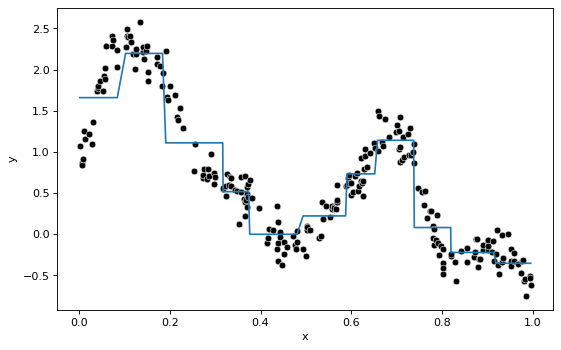

In [61]:
_, _  = reg_tree(d, n_bins=11, strategy="quantile")

---

### 🚩 Exercise 16

Use the `reg_tree` function to fit a variety of different discretized models to the data. What value of `n_bins` provides the best fit (judged qualitatively not quantitatively).

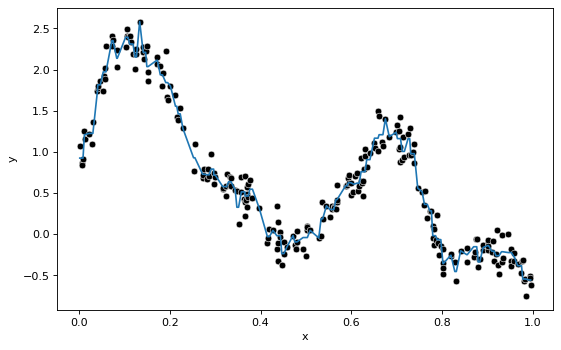

In [62]:
_,_ = reg_tree(d, n_bins=101)

Inceasing the number of bins gives the model more flexibility and hence seems to fit the data better. Behare of over fitting!

---

### 🚩 Exercise 17

Based on what you've seen in Exercise 13, how do you think the quality of fit changes as `n_bins` increases?

Inceasing the number of bins improves the overall model fit.